#2 DoF robot inverse kinematic

# SOM package

In [1]:
import numpy as np
import matplotlib.pyplot as plt

!pip install sklearn_som
from sklearn_som.som import SOM

# Robot

## Direct kinematic

In [2]:
def get_T_fun(a0, a1):
  return lambda theta0, theta1: \
                  (np.array([a0*np.cos(theta0), a0*np.sin(theta0)]) + \
                   np.array([a1*np.cos(theta1), a1*np.sin(theta1)])).T
  #c0 = np.array([
  #               [0, 0],
  #               [a0*np.cos(theta0), a0*np.sin(theta0)],
  #])
  #c1 = np.array([
  #               [0, 0],
  #               [a1*np.cos(theta1), a1*np.sin(theta1)],
  #]) + c0[1:]

##Initialization

In [3]:
a0, a1 = 1.0, 0.5
a = a0 + a1

T = get_T_fun(a0, a1)

##Status

In [4]:
def plot_coord_axes():
  plt.plot([0, 0], [-a, a], ':k')
  plt.plot([-a, a], [0, 0], ':k')
  plt.scatter(0, 0, c='k', s=200)
  plt.scatter(0, 0, c='r', s=50)
  plt.axis('equal')
  plt.axis([-a*1.1, a*1.1, -a*1.1, a*1.1])
  plt.xlabel('x coord')
  plt.ylabel('y coord')

def plot_control_axes():
  plt.plot([0, 0], [-180, 180], ':k')
  plt.plot([-180, 180], [0, 0], ':k')
  plt.scatter(0, 0, c='k', s=200)
  plt.scatter(0, 0, c='r', s=50)
  plt.axis('equal')
  plt.axis([-190, 190, -190, 190])
  plt.xlabel('theta0 control')
  plt.ylabel('theta1 control')

def plot_status(theta0, theta1):
  c0 = np.array([a0*np.cos(theta0), a0*np.sin(theta0)])
  c1 = np.array([a1*np.cos(theta1), a1*np.sin(theta1)]) + c0

  plt.figure()
  plt.plot([0,     c0[0]], [0,     c0[1]], 'r')
  plt.plot([c0[0], c1[0]], [c0[1], c1[1]], 'b')

  plt.scatter(c0[0], c0[1], c='b', s=50)
  plt.scatter(c1[0], c1[1], c='b', marker='x', s=100)
  plt.title('final coords (%.2f, %.2f)' % (c1[0], c1[1]))
  plt.legend(['theta%d: %.2f°' % (i, t/np.pi*180 % 360) for i, t in enumerate([theta0, theta1])])
  
  plot_coord_axes()

###Status example

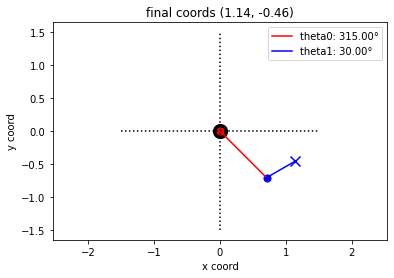

In [5]:
theta0_deg, theta1_deg = -45, 30
plot_status(theta0_deg/180 * np.pi, theta1_deg/180 * np.pi)

# Neuron space (i.e. Robot control space)

In [6]:
h = np.pi / 180  # step size in the mesh
Theta0, Theta1 = np.meshgrid(np.arange(-np.pi, np.pi, h), np.arange(-np.pi, np.pi, h))
Thetas = np.stack((Theta0.ravel(), Theta1.ravel()), 1)

# Feature space (i.e. Cartesian space)

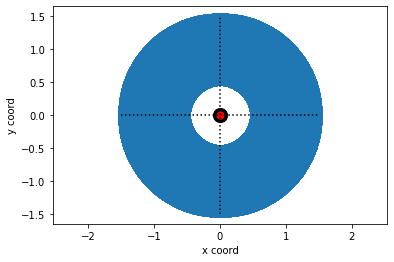

In [7]:
Points = T(Thetas[:,0], Thetas[:,1])
plt.scatter(Points[:, 0], Points[:, 1])
plot_coord_axes()

#SOM

##Architecture

In [8]:
M, N = 10, 10

som = SOM(m=M, n=N, dim=2)

## Training

In [9]:
epochs = 10

som.fit(Thetas, epochs)

## Inference

In [10]:
pred_training = som.predict(Thetas)

pred_training.shape, pred_training.min(), pred_training.max()

((129600,), 0, 99)

##Get the neuron/prototype for each cluster

In [11]:
cluster_thetas = som.cluster_centers_
cluster_thetas_deg = cluster_thetas / np.pi * 180
print('Cluster prototipe shape:', cluster_thetas.shape)

#cluster_points = T(cluster_thetas)

# Compute the theta prototypes by averaging
cluster_points = np.zeros_like(cluster_thetas)
for i in range(M):
  for j in range(N):
    cluster_points[i, j] = T(*cluster_thetas[i, j])

Cluster prototipe shape: (10, 10, 2)


##Cluster visualization

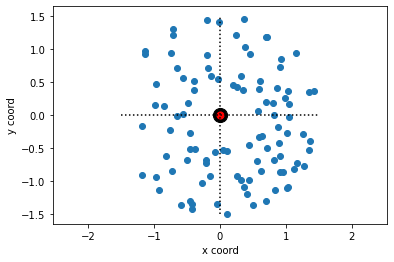

In [12]:
plt.scatter(cluster_points[:, :, 0].ravel(), cluster_points[:, :, 1].ravel())
plot_coord_axes()

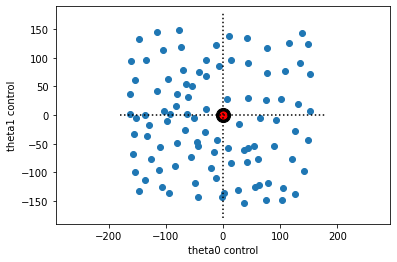

In [13]:
plt.scatter(cluster_thetas_deg[:, :, 0].ravel(), cluster_thetas_deg[:, :, 1].ravel())
plot_control_axes()

##Voronoy diagram

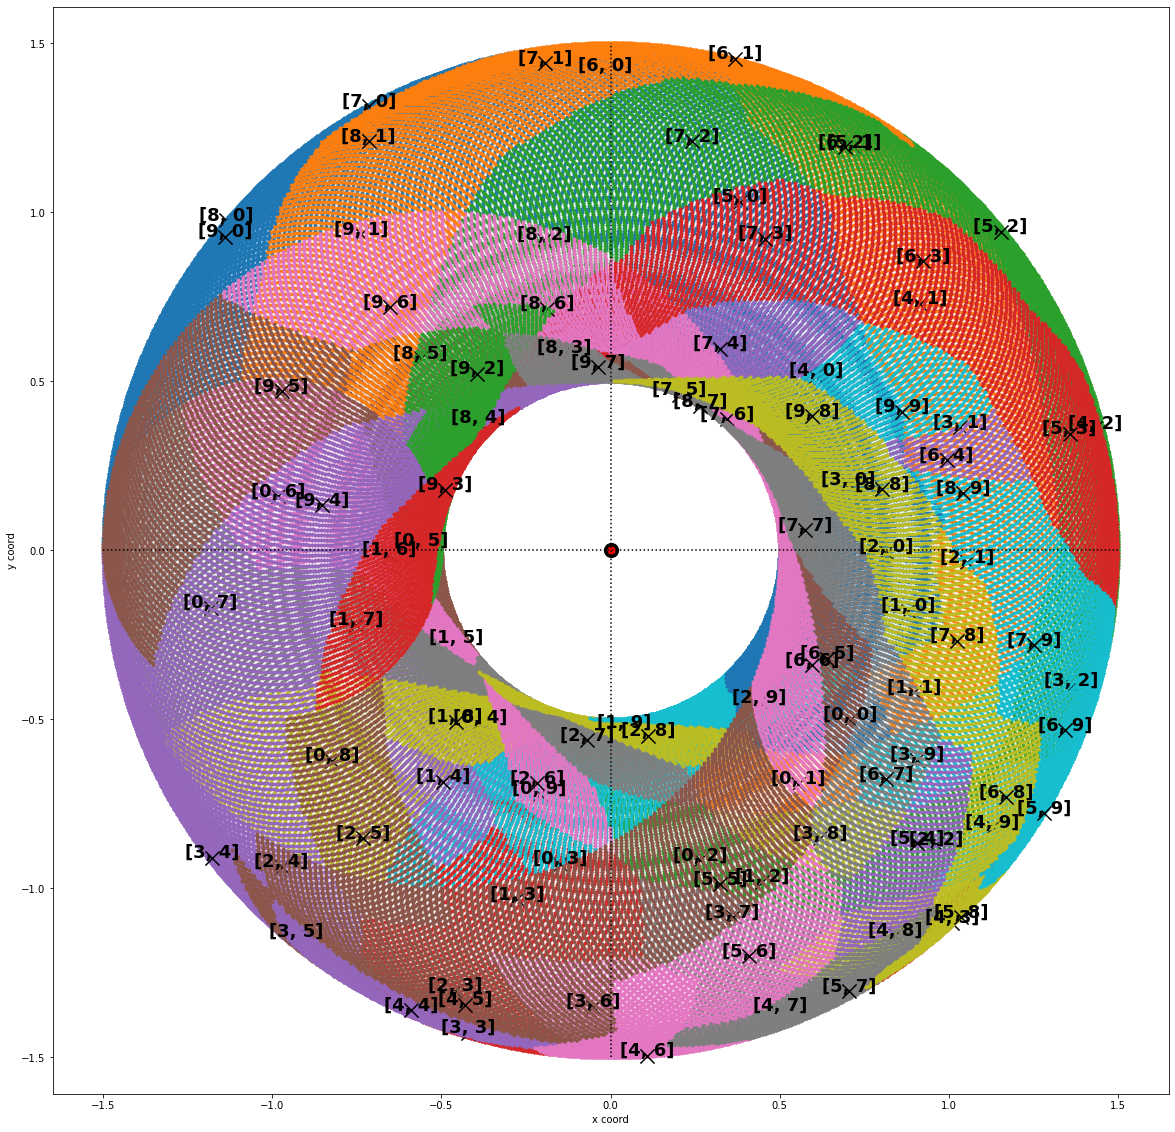

In [14]:
plt.figure(figsize=(20, 20))
plot_coord_axes()
for i in range(M):
  for j in range(N):
    ij = np.ravel_multi_index((i, j), (M, N))
    plt.scatter(Points[pred_training==ij, 0], Points[pred_training==ij, 1], marker='.')
    plt.scatter(cluster_points[i, j, 0], cluster_points[i, j, 1], marker='x', s=200, c='k')
    plt.text(cluster_points[i, j, 0], cluster_points[i, j, 1],
             '[%d, %d]' % (i, j),
             #'[%d, %d] (%.1f°, %.1f°)' % (i, j, cluster_thetas_deg[i, j, 0], cluster_thetas_deg[i, j, 1]),
             horizontalalignment='center', fontsize=18, weight='bold')

## Get the point for each neuron/prototype

Neuron [0, 1]:
- feature space coords (0.6, -0.7)


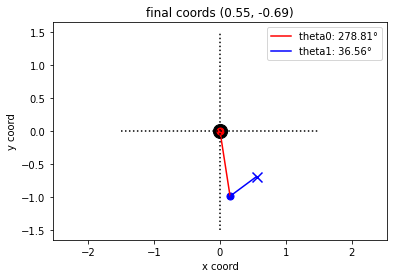

In [15]:
m_, n_ = 0, 1

plot_status(*cluster_thetas[m_, n_])
print('Neuron [%d, %d]:' % (m_, n_))
print('- feature space coords (%.1f, %.1f)' % (cluster_points[m_, n_, 0], cluster_points[m_, n_, 1]))

#Inverse kinematic

In [16]:
def inverse_kinematic(x, y, K=4):

  # compute the distance in the x-y space between the desired point and the
  # points corresponding to SOM neurons in the x-y space 
  point = np.array([[[x, y]]])
  dist = ((point - cluster_points) ** 2).sum(-1)
  
  if K == 1:
    # returns the closest SOM neuron (i.e., the closest point in the robot control space)
    M_max, N_max = np.unravel_index(np.argmin(dist.ravel()), (M, N))
    return cluster_thetas[M_max, N_max]

  # sort the distances and takes the ordered SOM indexes
  M_sorted, N_sorted = np.unravel_index(np.argsort(dist.ravel()), (M, N))

  # takes the K closest SOM neurons (i.e., the K closest points the robot control space)
  neighbors = np.stack([cluster_thetas[M_sorted[k], N_sorted[k]] for k in range(K)])
  neighbors_distance = np.stack([dist[M_sorted[k], N_sorted[k]] for k in range(K)])
  
  # convert distances in the x-y space to similarities (Gaussian weights)
  neighbors_similarity = np.exp(-neighbors_distance)
  neighbors_similarity /= neighbors_similarity.sum()
  neighbors_similarity = np.expand_dims(np.stack(neighbors_similarity), 1)

  # returns the weighted average of the closest SOM neurons
  return (neighbors * neighbors_similarity).sum(0)


## Nearest neuron/prototype

In [17]:
#x_, y_ = 0.75, 1.0
#x_, y_ = a0+a1, 0
x_, y_ = 0, a0+a1

t0_, t1_ = inverse_kinematic(x_, y_, K=1)

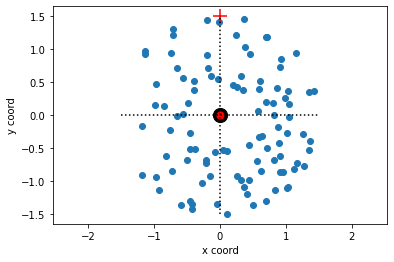

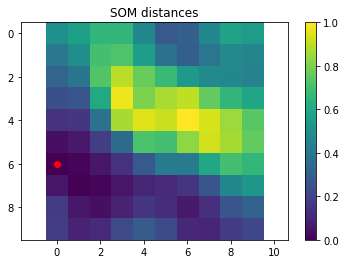

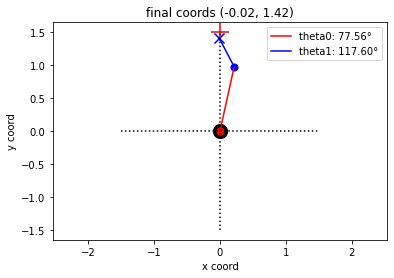

In [23]:
plt.figure()
plt.scatter(cluster_points[:, :, 0].ravel(), cluster_points[:, :, 1].ravel())
plt.scatter(x_, y_, c='r', marker='+', s=200)
plot_coord_axes()

point = np.array([[[x_, y_]]])
dist = ((point - cluster_points) ** 2).sum(-1)
m_, n_ = np.unravel_index(np.argmin(dist.ravel()), (M, N))

plt.figure()
plt.imshow(dist)
plt.scatter(n_, m_, c='r')
plt.axis('equal')
plt.colorbar()
plt.title('SOM distances')

plot_status(t0_, t1_)
plt.scatter(x_, y_, marker='+', c='r', s=300)

## Neuron interpolation

Desired point: 0 1.5


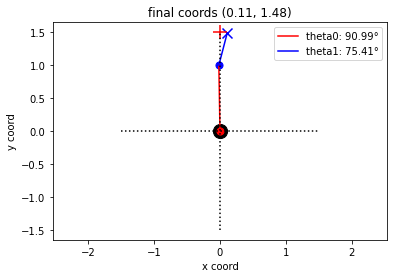

In [19]:
t0_int, t1_int = inverse_kinematic(x_, y_, K = 4)

plot_status(t0_int, t1_int)
plt.scatter(x_, y_, marker='+', c='r', s=200)

print('Desired point:', x_, y_)